In [ ]:
from pharynx_analysis import experiment
import logging

logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')

In [36]:
from scipy import ndimage
from skimage.external import tifffile
from tqdm import tqdm_notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pharynx_analysis import (
    pharynx_io as pio, image_processing as ip, 
    experiment, plots, profile_processing as pp, data_analysis as da
)

from importlib import reload

reload(pio);
reload(ip);
reload(experiment);
reload(da);

import logging

logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')

In [5]:
mvmt = da.load_all_movement('/Users/sean/code/wormAnalysis/data/paired_ratio')
mvmt = mvmt.pivot_table(index=['experiment', 'animal'], columns=['pair', 'region']).reset_index()

In [6]:
all_rot_fl = pio.load_all_rot_fl()
all_rot_seg = pio.load_all_rot_fl()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/sean/code/wormAnalysis/python/data/paired_ratio/all_rot_fl.nc'

In [7]:
mvmt_0 = mvmt.xs('movement',  axis=1).loc[pd.IndexSlice[:,0]]
mvmt_1 = mvmt.xs('movement',  axis=1).loc[pd.IndexSlice[:,1]]

mvmt_0['total'] = mvmt_0['anterior'] + mvmt_0['posterior'] + mvmt_0['sides_of_tip'] + mvmt_0['tip']
mvmt_1['total'] = mvmt_1['anterior'] + mvmt_1['posterior'] + mvmt_1['sides_of_tip'] + mvmt_1['tip']

nonmovers_0 = mvmt_0[mvmt_0.total == 0].index.values
nonmovers_1 = mvmt_1[mvmt_1.total == 0].index.values

In [4]:
dxs = np.linspace(-1,1,50)
dys = np.zeros(len(dxs))
vecs = np.vstack([dxs, dys]).T

rot_fl_0_sta = all_rot_fl.sel(pair=0)[nonmovers_0]
rot_fl_1_sta = all_rot_fl.sel(pair=1)[nonmovers_1]

rs_0 = np.zeros((rot_fl_0_sta.shape[0]*len(vecs), rot_fl_0_sta.shape[-2],  rot_fl_0_sta.shape[-1]))
rs_0_seg = np.zeros((rot_fl_0_sta.shape[0]*len(vecs), rot_fl_0_sta.shape[-2],  rot_fl_0_sta.shape[-1]))
rs_1_seg = np.zeros((rot_fl_1_sta.shape[0]*len(vecs), rot_fl_1_sta.shape[-2],  rot_fl_1_sta.shape[-1]))
rs_1 = np.zeros((rot_fl_1_sta.shape[0]*len(vecs), rot_fl_1_sta.shape[-2],  rot_fl_1_sta.shape[-1]))

meas_410 = [np.zeros((rot_fl_0_sta.shape[0]*len(vecs), 300)), np.zeros((rot_fl_1_sta.shape[0]*len(vecs), 300))]
meas_470 = [np.zeros((rot_fl_0_sta.shape[0]*len(vecs), 300)), np.zeros((rot_fl_1_sta.shape[0]*len(vecs), 300))]
meas_470_shifted = [np.zeros((rot_fl_0_sta.shape[0]*len(vecs), 300)), np.zeros((rot_fl_1_sta.shape[0]*len(vecs), 300))]

for (rs, rot_fl, rot_seg), pair in zip([(rs_0,rot_fl_0_sta, rs_0_seg), (rs_1,rot_fl_1_sta, rs_1_seg)], [0, 1]):
    idx = 0
    for i in tqdm_notebook(range(rot_fl.strain.size)):
        i410 = rot_fl.sel(wavelength='410').isel(spec=i).values
        i470 = rot_fl.sel(wavelength='470').isel(spec=i).values
        
        for j in range(vecs.shape[0]):
            i470_shifted = ip.shift(i470, vecs[j])
            rot_seg[idx] = i410 > 2000
            mid = ip.calculate_midline(rot_seg[idx])
            meas_410[pair][idx] = ip.measure_under_midline(i410, mid, mid.linspace(300)[0])
            meas_470[pair][idx] = ip.measure_under_midline(i470, mid, mid.linspace(300)[0])
            meas_470_shifted[pair][idx] = ip.measure_under_midline(i470_shifted, mid, mid.linspace(300)[0])
            idx += 1

NameError: name 'all_rot_fl' is not defined

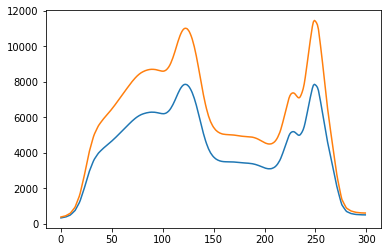

In [25]:
ax = plots.plot_profile_avg_with_bounds(all_meas_470)
plots.plot_profile_avg_with_bounds(all_meas_410, ax=ax)


In [35]:
reload(plots);
r_unshifted = (all_meas_410 / all_meas_470)
r_shifted = all_meas_410 / all_meas_470_shifted

/Users/sean/.local/share/virtualenvs/worm/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/Users/sean/.local/share/virtualenvs/worm/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [50]:
mvmt_mag = np.concatenate([np.tile(vecs[:,0], rot_fl_0_sta.shape[0]), np.tile(vecs[:,0], rot_fl_1_sta.shape[0])])

In [12]:
all_meas_410 = np.concatenate(meas_410, 0)
all_meas_470 = np.concatenate(meas_470, 0)
all_meas_470_shifted = np.concatenate(meas_470_shifted, 0)

In [99]:
all_r_stat = all_meas_410 / all_meas_470
all_r_shift = all_meas_410 / all_meas_470_shifted

rr = all_r_stat / all_r_shift
# rr = np.reshape(rr, (rot_fl_0_sta.shape[0] + rot_fl_1_sta.shape[0], 50, 300))

/Users/sean/.local/share/virtualenvs/worm/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/Users/sean/.local/share/virtualenvs/worm/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


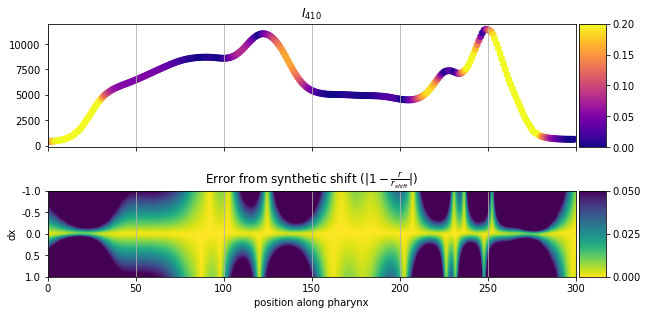

In [358]:
reshaped = np.reshape(rr, (rot_fl_0_sta.shape[0] + rot_fl_1_sta.shape[0], 50, 300))

from mpl_toolkits.axes_grid1 import make_axes_locatable


fig, axes = plt.subplots(2,1, figsize=(10,5), sharex=True)

err_shift = np.abs(1-np.nanmean(reshaped, axis=0))
err_fwd = err_shift[26:,:]

err_slope = (err_fwd[-1,:] - err_fwd[0,:])

scatter = axes[0].scatter(np.arange(all_meas_410.shape[-1]), np.mean(all_meas_410, axis=0), c=err_slope, vmax=0.2, cmap='plasma')
axes[0].set_xlim(0, 300)

divider0 = make_axes_locatable(axes[0])
cax = divider0.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(scatter, cax=cax, orientation='vertical')
# cax.set_axis_off()
divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)


im = axes[1].imshow(
    np.abs(1-np.nanmean(reshaped, axis=0)),
    cmap=plt.get_cmap('viridis_r'),
    interpolation='bicubic'
)
im.set_clim(0,0.05)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
regions: dict = {
    "pm3": [0.07, 0.28],
    "pm4": [0.33, 0.45],
    "pm5": [0.53, 0.70],
    "pm6": [0.80, 0.86],
    "pm7": [0.88, 0.96],
}
regions = {x: np.array(regions[x]) * 250 for x in regions.keys()}

axes[0].grid(True, axis='x')
axes[1].grid(True, axis='x')
axes[1].set_yticks(np.linspace(0, 49, 5))
axes[1].set_yticklabels(np.linspace(-1, 1, 5))
axes[1].set_ylabel('dx')
axes[1].set_xlabel('position along pharynx')
axes[1].set_title(r'Error from synthetic shift ($|1-\frac{r}{r_{shift}}|$)')
axes[0].set_title(r'$I_{410}$')
cbar.set_ticks(np.linspace(0,0.05,3))


# axes[1].set_yticks(np.arange(-1, 1, 0.05));
# plots.add_regions_to_axis(axes[1], regions, alpha=0.1, color='red')
# plots.add_regions_to_axis(axes[0], regions, alpha=0.1, color='red')

plt.savefig('/Users/sean/code/wormAnalysis/data/synthetic_error_analysis/synthetic_error_stability.pdf')

# Rearranging DataFrame for Movement Order

In [8]:
idx = pd.IndexSlice
mvmt = mvmt[mvmt.experiment == '2017_02_22-HD233_SAY47']
mvmt_logical_idx = (mvmt['movement'].loc[:, 1] == 0) & (mvmt['movement'].loc[:, 0] != 0)
# mvmt_logical_idx.index.rename('animal', inplace=True)
mvmt_logical_idx.index.names = ['animal']
mvmt_logical_idx.sample(n=5)

region,anterior,posterior,sides_of_tip,tip
animal,,,,
1,False,False,False,False
23,True,True,True,True
111,False,False,False,False
5,True,False,True,False
19,False,False,False,False


In [9]:
mvmt.head()

experiment animal movement                             \
pair                                         0                              
region                                anterior posterior sides_of_tip tip   
animal                                                                      
0       2017_02_22-HD233_SAY47      0        0         0            0   1   
1       2017_02_22-HD233_SAY47      1        0         0            1   0   
2       2017_02_22-HD233_SAY47      2        0         0            0   0   
3       2017_02_22-HD233_SAY47      3        0         0            0   0   
4       2017_02_22-HD233_SAY47      4        0         0            0   0   

                                            
pair          1                             
region anterior posterior sides_of_tip tip  
animal                                      
0             0         0            0   0  
1             1         1            1   1  
2             0         0            0   0  
3             0         0            0   0  
4             0         0            0   0

In [54]:
def split_by_movement_types(df, roi, t=0):
    """ Return a set of filtered DataFrames, according to the following scheme:
    
    m_0_0:
        no movement in the 0th or 1st pair
    m_0_1:
        no movement in the 0th pair, movement in the 1st pair
    m_1_0:
        movment in the 0th pair, no movement in the 1st pair
    m_1_1:
        movment in both pairs
    
    In each case, movement is classified as such if the movement call *within the given ROI* is greater than 
    the specified threshold (default=0).
    
    returned in the following order:
        (m_0_0, m_0_1, m_1_0, m_1_1)
    
    """
    mt= df[((df['movement'].loc[:, 0][roi] <= t) & (df['movement'].loc[:, 1][roi] <= t))]
    m_0_1 = df[((df['movement'].loc[:, 0][roi] <= t) & (df['movement'].loc[:, 1][roi]  > t))]
    m_1_0 = df[((df['movement'].loc[:, 0][roi]  > t) & (df['movement'].loc[:, 1][roi] <= t))]
    m_1_1 = df[((df['movement'].loc[:, 0][roi]  > t) & (df['movement'].loc[:, 1][roi]  > t))]
    
    return m_0_0, m_0_1, m_1_0, m_1_1

m_0_0, m_0_1, m_1_0, m_1_1 = split_by_movement_types(mvmt, 'anterior', t=1)
# m_0_1.head()
m_1_0.head()

experiment animal movement                             \
pair                                         0                              
region                                anterior posterior sides_of_tip tip   
animal                                                                      
88      2017_02_22-HD233_SAY47     88        2         2            0   2   
90      2017_02_22-HD233_SAY47     90        3         3            3   3   
97      2017_02_22-HD233_SAY47     97        3         2            3   2   
115     2017_02_22-HD233_SAY47    115        3         3            1   2   
119     2017_02_22-HD233_SAY47    119        3         3            3   3   

                                            
pair          1                             
region anterior posterior sides_of_tip tip  
animal                                      
88            1         0            0   0  
90            0         0            0   0  
97            1         1            2   1  
115           0         0            0   0  
119           0         0            0   1

In [53]:
# Selects idx where ROI moved but !ROI did not
roi = 'anterior'
pair = 1
da.filter_only_moving_roi(mvmt, pair, roi)

experiment animal movement                             \
pair                                         0                              
region                                anterior posterior sides_of_tip tip   
animal                                                                      
88      2017_02_22-HD233_SAY47     88        2         2            0   2   
101     2017_02_22-HD233_SAY47    101        0         0            0   0   

                                            
pair          1                             
region anterior posterior sides_of_tip tip  
animal                                      
88            1         0            0   0  
101           1         0            0   0

In [30]:
params = dict(
    experiment_dir="/Users/sean/code/wormAnalysis/data/paired_ratio/2017_02_22-HD233_SAY47/",
    imaging_scheme="TL/470/410/470/410"
)

ex_unreg = experiment.PairExperiment(**params).full_pipeline()
# ex_reg = experiment.PairExperiment(**params, should_register=True).full_pipeline()

100%|██████████| 123/123 [00:01<00:00, 108.09it/s]
